# MCMC Adaptive

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from mcmc import *
from mcmc_adaptive import estimate_covariance
from mcmc_plots import (plot_trace_mcmc, plot_marginal_distributions, 
                       plot_autocorrelations, plot_distribution, pairplot)
%load_ext autoreload
%autoreload 2

In [3]:
FONTSIZE=16
LABELSIZE=0.9*FONTSIZE
LINEWIDTH=2.0
FIGWIDTH=8
ASPECT_RATIO=4/3

plt.rcParams['axes.labelsize'] = FONTSIZE
plt.rcParams['axes.linewidth'] = LINEWIDTH
plt.rcParams['axes.titlesize'] = 1.1*FONTSIZE
plt.rcParams['figure.figsize'] = [FIGWIDTH, FIGWIDTH/ASPECT_RATIO]
plt.rcParams['figure.labelsize'] = FONTSIZE
plt.rcParams['figure.titlesize'] = 1.1*FONTSIZE
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['legend.fontsize'] = LABELSIZE
plt.rcParams['legend.title_fontsize'] = LABELSIZE
plt.rcParams['patch.linewidth'] = LINEWIDTH
plt.rcParams['lines.linewidth'] = LINEWIDTH
plt.rcParams['xtick.labelsize'] = LABELSIZE
plt.rcParams['ytick.labelsize'] = LABELSIZE
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.autolayout'] = True

plt.rcParams['patch.edgecolor'] = 'black'

In [4]:
DATA_PATH = "GRBs/GRB_data.txt"
arr = np.loadtxt(DATA_PATH, skiprows=1)

### Adaptive + Frozen runs

In [26]:
LOAD = False

rng = np.random.default_rng(1234)

logT90       = arr[:,0]
sigma_logT90 = arr[:,1]

theta_true = {"w": 0.3, "mu1": -0.5, "mu2": 3.5, "sigma1": 0.8, "sigma2": 1.0}
logT90 = generate_data(theta_true, N = len(logT90), rng=rng, sigma_logT90=sigma_logT90)

theta_sim = np.array((theta_true['w'], 
                    theta_true['mu1'], 
                    theta_true['mu2']-theta_true['mu1'], 
                    theta_true['sigma1'],
                    theta_true['sigma2'])) 

print('logL (simulation)= ', log_likelihood(logT90, theta_sim, sigma_logT90))

# define the prior bounds
#bounds = [[0,1],[-3,2], [0, 6], [0,4], [0,4]]

bounds = [
    [0.0, 1.0],     # w
    [-4, 7],        # mu1 (ln s)
    [0.0, 10.0],    # delta = mu2 - mu1
    [1e-1, 6.0],    # sigma1 (in log-space)
    [1e-1, 6.0]     # sigma2
]

if LOAD == 0:
    n_steps            = 50000
    sigma_logT90       = 0.0 # se 0: misure senza errore
    max_adapt          = 100000
    adapt_interval     = 2000
    min_adapt          = 10000
    eps                = 1e-8
    tol_logdet         = 2e-2
    consecutive_stable = 3
    
    # 1) inizializzazione parametri
    theta0  = init_theta_from_data(logT90, bounds)
    
    # 1) stima cov durante burnin
    cov_est, mean_est, samples_adapt, overall_acc, cov_history, vol_history = estimate_covariance(
        theta0, logT90, bounds, rng, sigma_logT90,
        max_adapt, adapt_interval, min_adapt, eps, tol_logdet, consecutive_stable )
    
    samples = metropolis_hastings(mean_est, logT90, bounds, init_cov=cov_est,
                                  rng = rng, sigma_logT90 = sigma_logT90, n = n_steps)
    np.savetxt('chain_adaptive.txt',samples)
else:
    samples = np.loadtxt('chain_adaptive.txt')

logL (simulation)=  -3730.0687128964673
[adapt t=10000] overall_acc=0.079 acc_window=0.144 delta_logdet=-3.9002e-01 (~-32.296%) stable_count=0
[adapt t=12000] overall_acc=0.093 acc_window=0.163 delta_logdet=-3.7336e-01 (~-31.158%) stable_count=0
[adapt t=14000] overall_acc=0.101 acc_window=0.147 delta_logdet=-2.7192e-01 (~-23.809%) stable_count=0
[adapt t=16000] overall_acc=0.108 acc_window=0.160 delta_logdet=-2.3838e-01 (~-21.210%) stable_count=0
[adapt t=18000] overall_acc=0.114 acc_window=0.163 delta_logdet=-2.7048e-01 (~-23.699%) stable_count=0
[adapt t=20000] overall_acc=0.121 acc_window=0.183 delta_logdet=-1.7245e-01 (~-15.840%) stable_count=0
[adapt t=22000] overall_acc=0.128 acc_window=0.196 delta_logdet=-1.1169e-01 (~-10.568%) stable_count=0
[adapt t=24000] overall_acc=0.133 acc_window=0.184 delta_logdet=-1.2365e-01 (~-11.631%) stable_count=0
[adapt t=26000] overall_acc=0.139 acc_window=0.216 delta_logdet=-6.7191e-02 (~-6.498%) stable_count=0
[adapt t=28000] overall_acc=0.145 

Acceptance rate = 0.2789

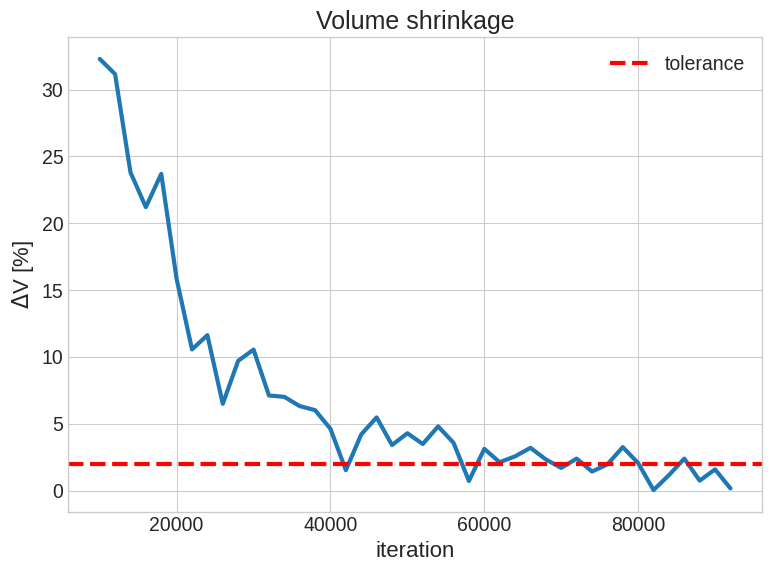

In [57]:
#fig = plt.figure(1, figsize=(8,4))
iter = np.linspace(min_adapt, samples_adapt.shape[0]-1, len(vol_history))
plt.plot(iter, np.abs(np.asarray(vol_history)), linewidth=3)
plt.axhline((np.exp(tol_logdet)-1)*100, linestyle='--', color='r', label='tolerance', linewidth=3)
plt.ylabel(r'$\Delta$V [%]')
plt.xlabel('iteration')
plt.title('Volume shrinkage')
plt.legend()
plt.savefig('figure/volume_contractions.png')
plt.show()

Saved: figure/trace_plot_mcmc_frozen.png (PNG 300 dpi) and figure/trace_plot_mcmc_frozen.pdf (PDF)


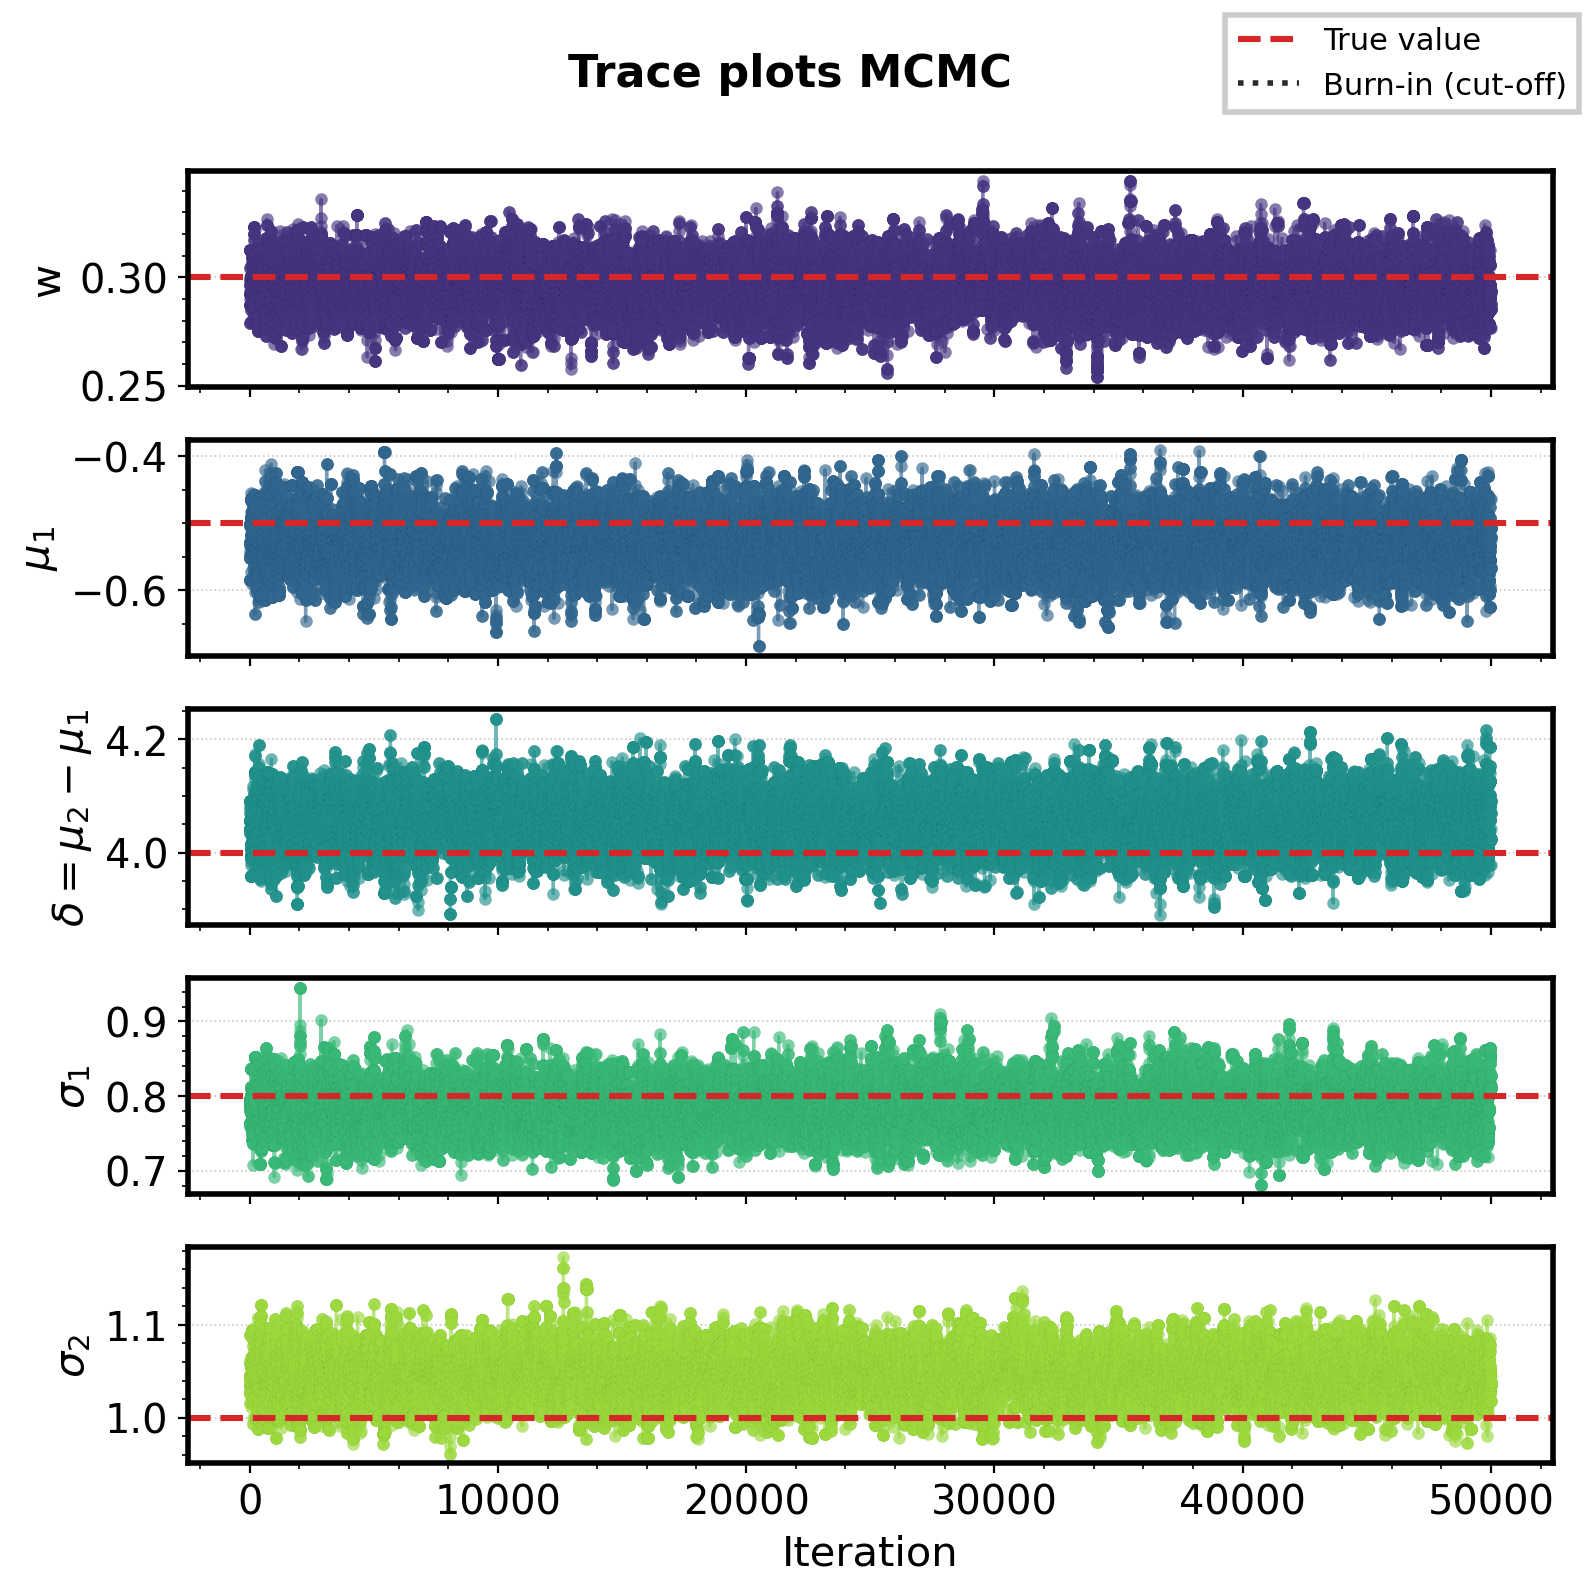

In [36]:
filename = 'trace_plot_mcmc_frozen'
fig, axes = plot_trace_mcmc(samples, filename, theta_sim, burnin=None, save=True)

In [37]:
burnin = 0
samples_new = samples[burnin:,:]

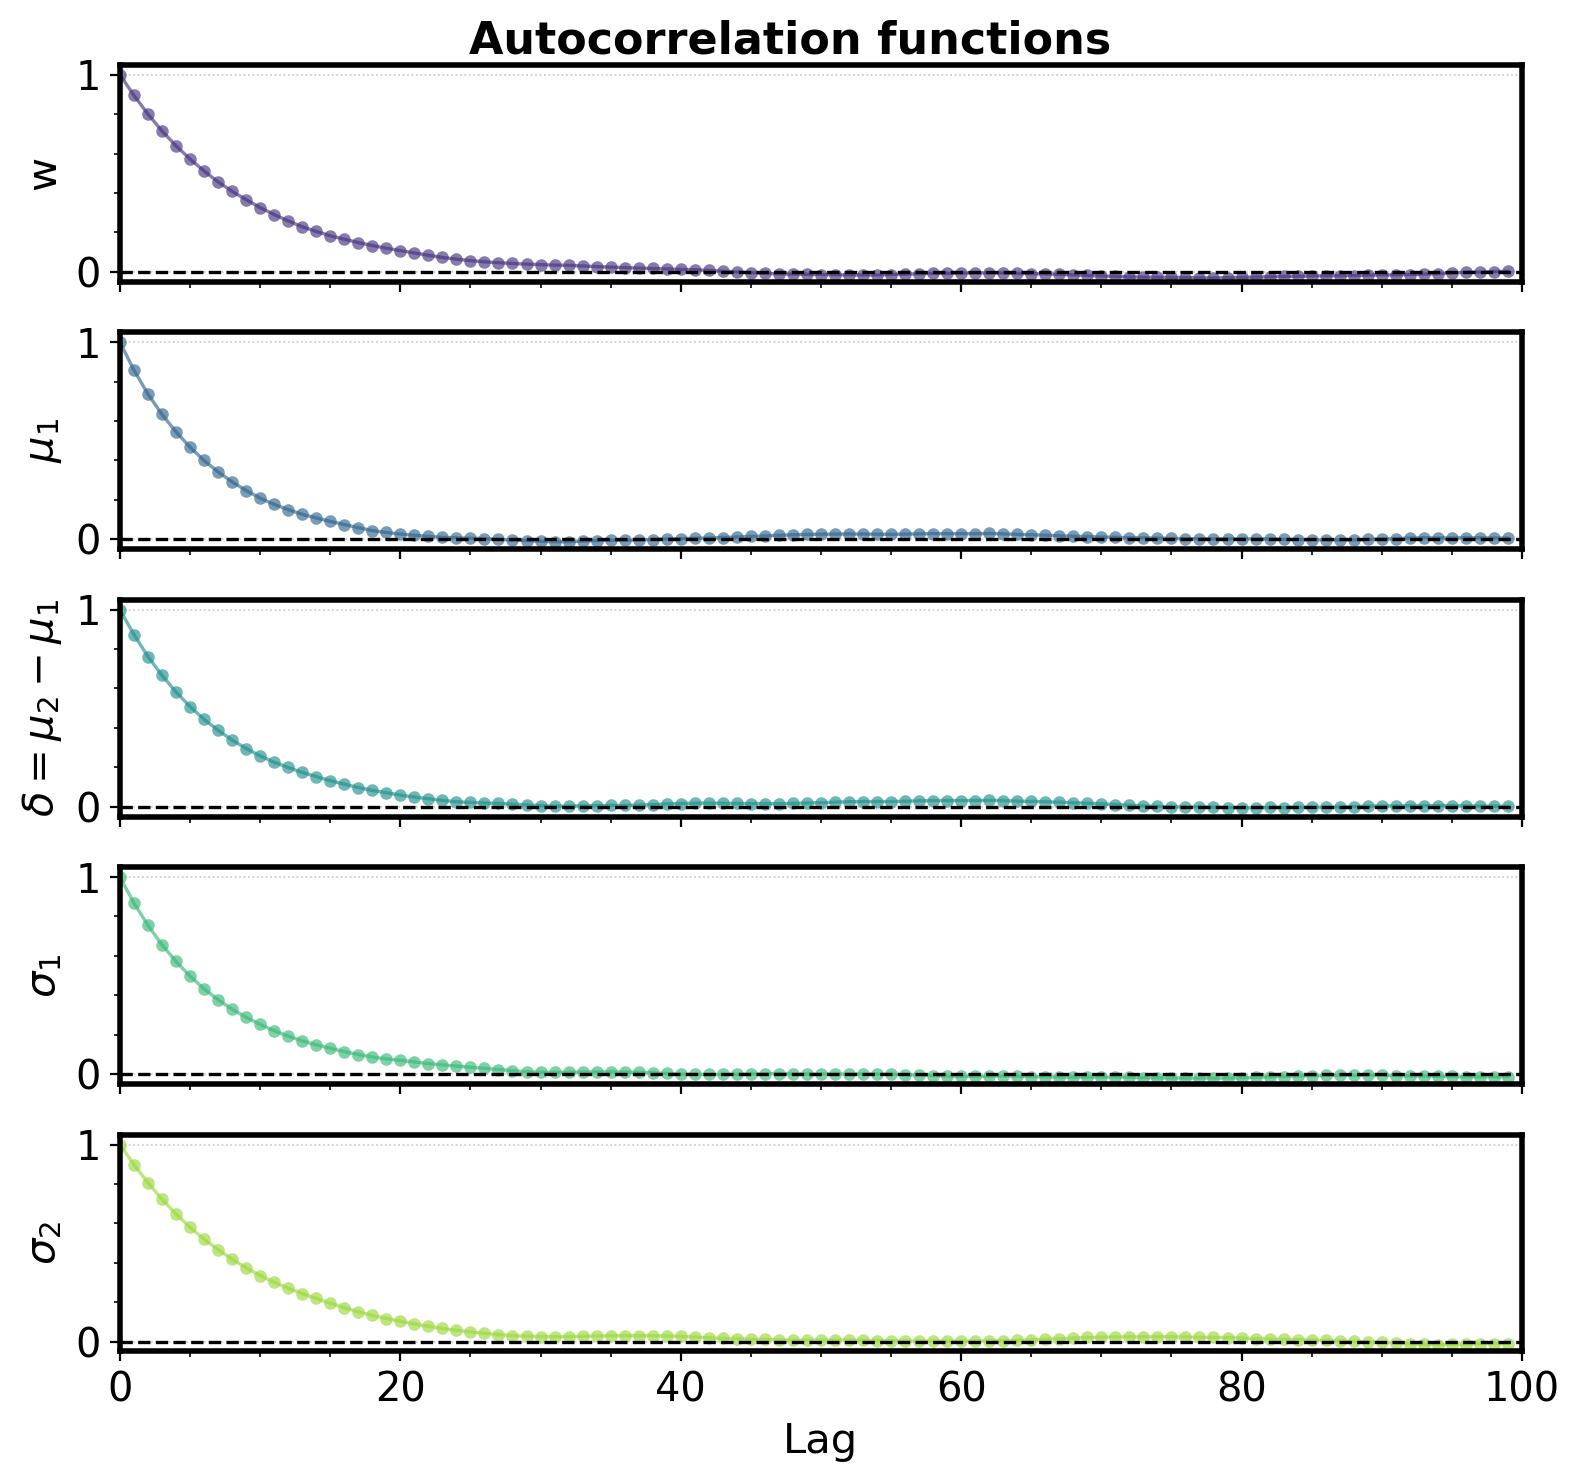

In [38]:
filename = 'autocorrelation_mcmc_frozen'
fig3, axes3 = plot_autocorrelations(samples_new, filename, max_lag=100, save=True)

In [39]:
for i, key in enumerate(theta_true.keys()):
    print(f'N_ESS ({key}) = {ess(samples_new[:,i]):.0f}')

N_ESS (w) = 2822
N_ESS (mu1) = 4048
N_ESS (mu2) = 3144
N_ESS (sigma1) = 3447
N_ESS (sigma2) = 2623


In [40]:
cov_est_final = np.cov(samples_new, rowvar=False)
print('covarianza =\n', cov_est_final)

mean_est_final = np.mean(samples_new, axis=0)

covarianza =
 [[ 1.20398527e-04  6.19615537e-05 -3.35530454e-05  4.94073826e-05
  -3.49279849e-05]
 [ 6.19615537e-05  1.37515318e-03 -1.18348328e-03  2.77299921e-04
  -1.87594714e-04]
 [-3.35530454e-05 -1.18348328e-03  1.90993094e-03 -1.06453525e-04
   3.34344884e-05]
 [ 4.94073826e-05  2.77299921e-04 -1.06453525e-04  8.23332884e-04
  -1.39871180e-04]
 [-3.49279849e-05 -1.87594714e-04  3.34344884e-05 -1.39871180e-04
   5.61177296e-04]]


In [41]:
thinning = 30
samples_new = samples_new[::thinning,:]
samples_new.shape

(1667, 5)

/home/leo/Desktop/Bayesian_probability/mcmc_plots.py:273: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(png_path, dpi=300, bbox_inches='tight', pad_inches=0.06)
/home/leo/Desktop/Bayesian_probability/mcmc_plots.py:274: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(pdf_path, dpi=300, bbox_inches='tight', pad_inches=0.06)


Saved: figure/marginal_distribution_mcmc_frozen.png (PNG 300 dpi) and figure/marginal_distribution_mcmc_frozen.pdf (PDF)


/home/leo/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


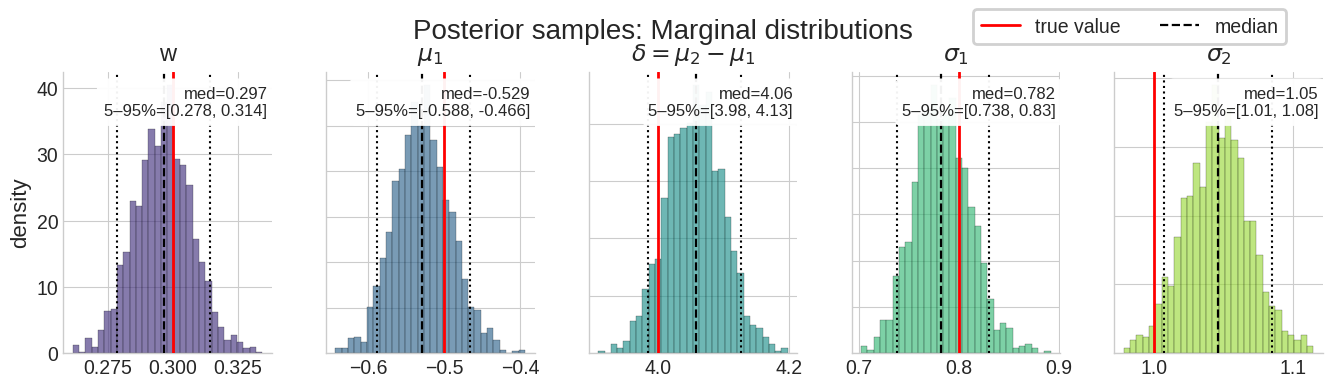

In [42]:
filename = 'marginal_distribution_mcmc_frozen'
fig2, axes2 = plot_marginal_distributions(samples_new, filename, theta_sim, save=True)

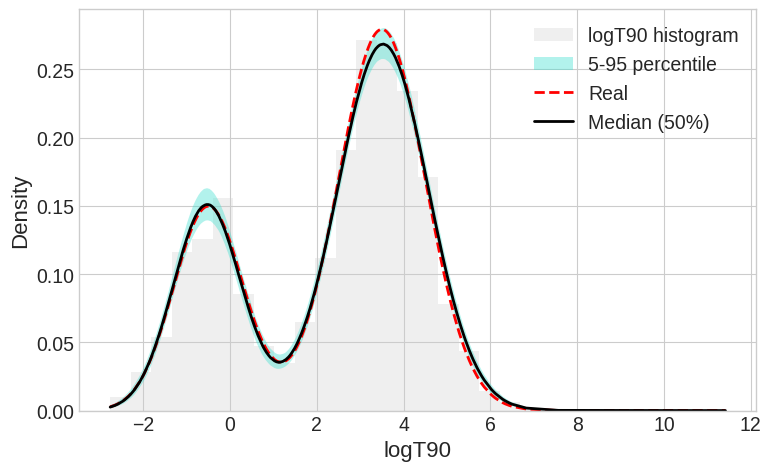

In [43]:
filename = 'distribution_mcmc_frozen'
fig4, axes4 = plot_distribution(logT90, samples_new, filename, theta_true=theta_sim, save=True)

### Final run

In [44]:
if LOAD == 0:
    samples = metropolis_hastings(mean_est_final, logT90, bounds, init_cov=cov_est_final,
                              rng = rng, sigma_logT90 = sigma_logT90, n = n_steps)
    np.savetxt('chain_final.txt',samples)
else:
    samples = np.load('chain_final.txt')

iteration 0: acceptance 0.5
iteration 2500: acceptance 0.33573141486810554
iteration 5000: acceptance 0.32966813274690127
iteration 7500: acceptance 0.32777925886430287
iteration 10000: acceptance 0.32623475304939015
iteration 12500: acceptance 0.3258678611422172
iteration 15000: acceptance 0.3230235968537528
iteration 17500: acceptance 0.3193349331504971
iteration 20000: acceptance 0.32041795820417956
iteration 22500: acceptance 0.3189938672118034
iteration 25000: acceptance 0.3184945204383649
iteration 27500: acceptance 0.31899498218311395
iteration 30000: acceptance 0.31764549030064665
iteration 32500: acceptance 0.3180419666482063
iteration 35000: acceptance 0.3181818181818182
iteration 37500: acceptance 0.3172364140579169
iteration 40000: acceptance 0.3174841257937103
iteration 42500: acceptance 0.31683214907533763
iteration 45000: acceptance 0.3171859028487623
iteration 47500: acceptance 0.31695507557576524
Metropolis finished. Acceptance rate = 0.3171


Acceptance rate = 0.3171

Saved: figure/trace_plot_mcmc_final.png (PNG 300 dpi) and figure/trace_plot_mcmc_final.pdf (PDF)


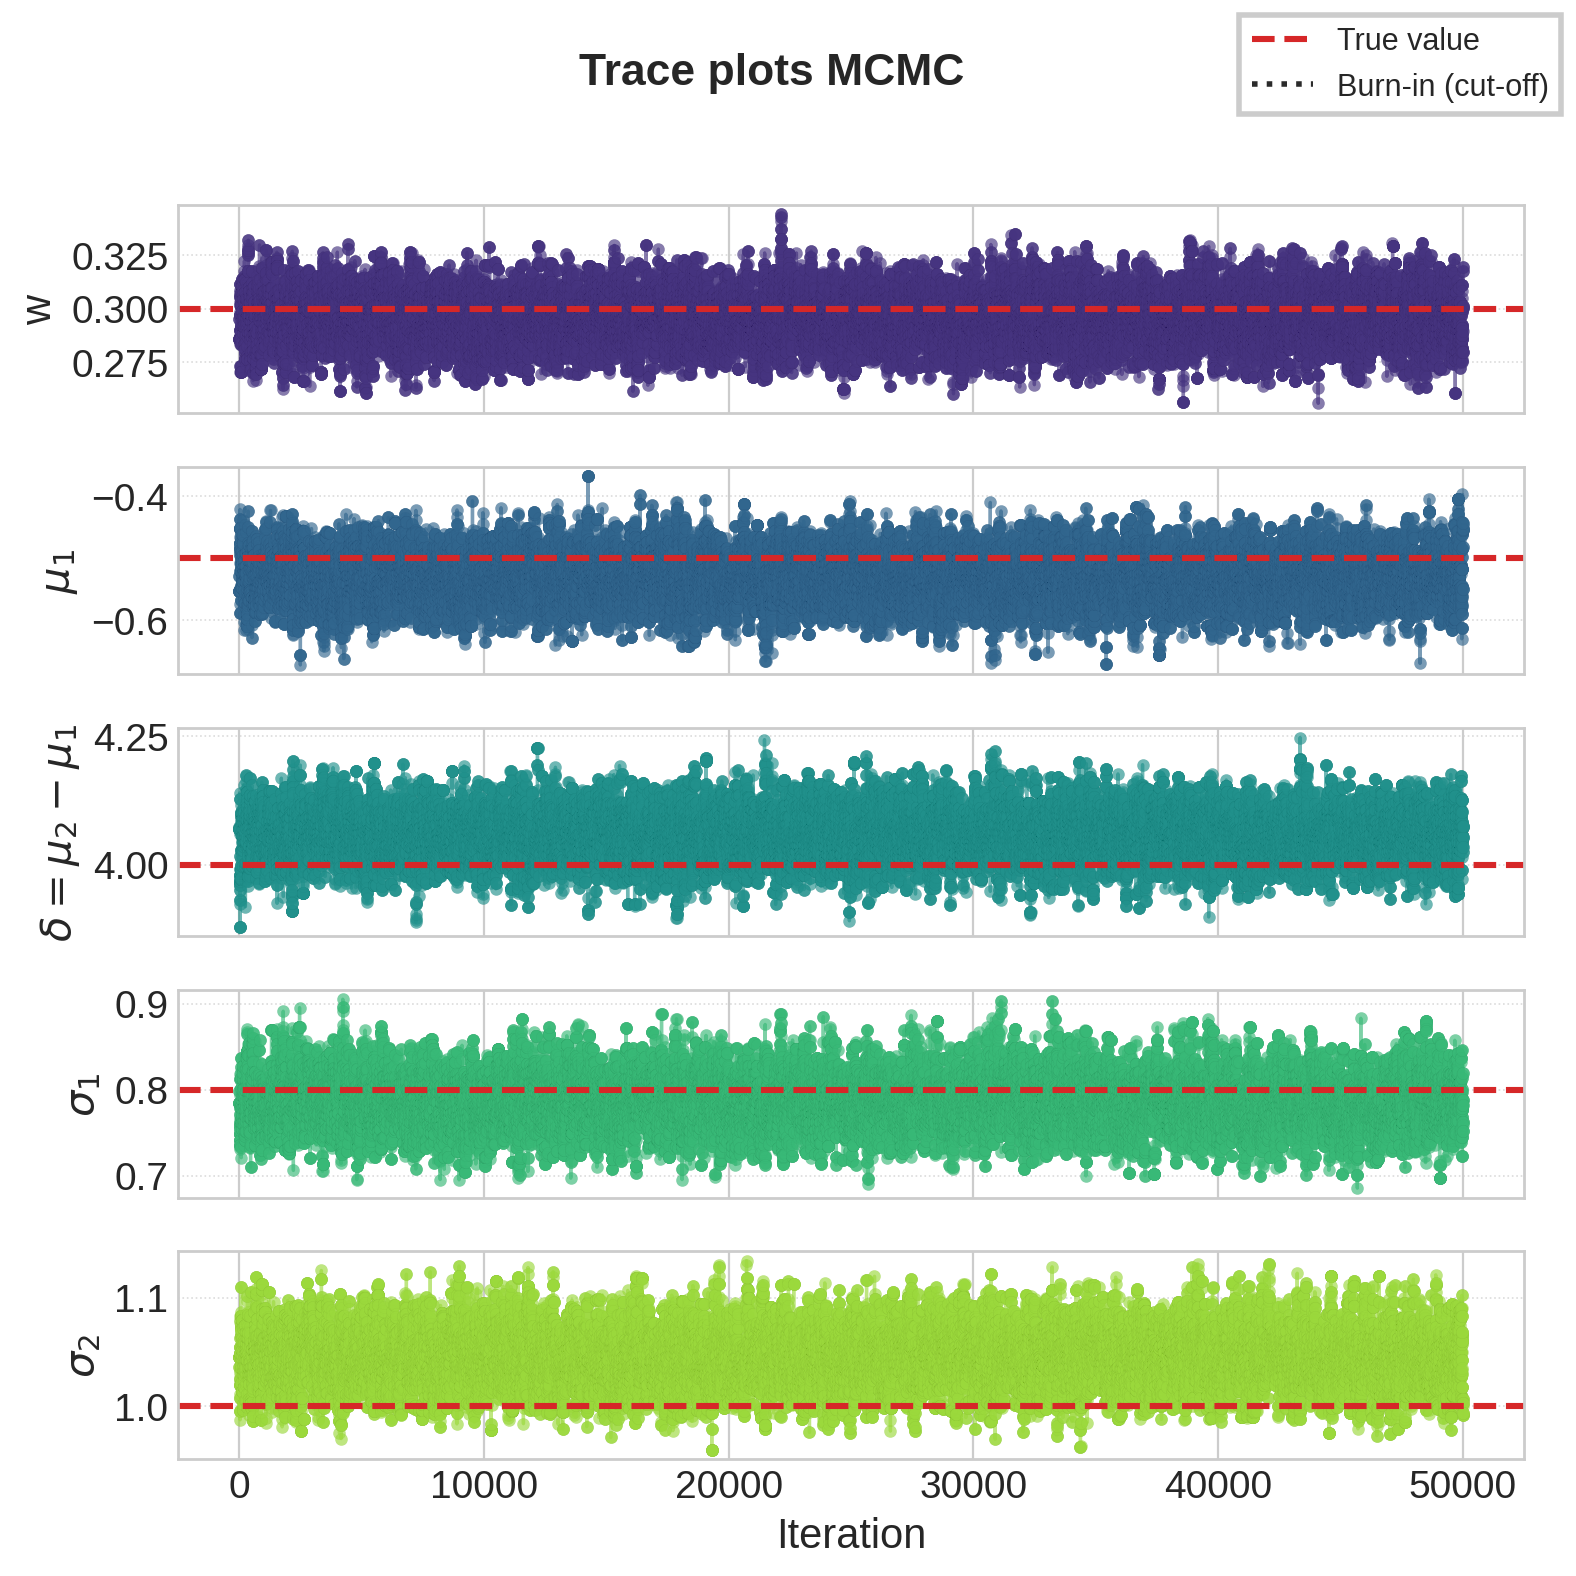

In [45]:
filename = 'trace_plot_mcmc_final'
fig, axes = plot_trace_mcmc(samples, filename, theta_sim, burnin=None, save=True)

In [46]:
burnin = 0
samples_new = samples[burnin:,:]

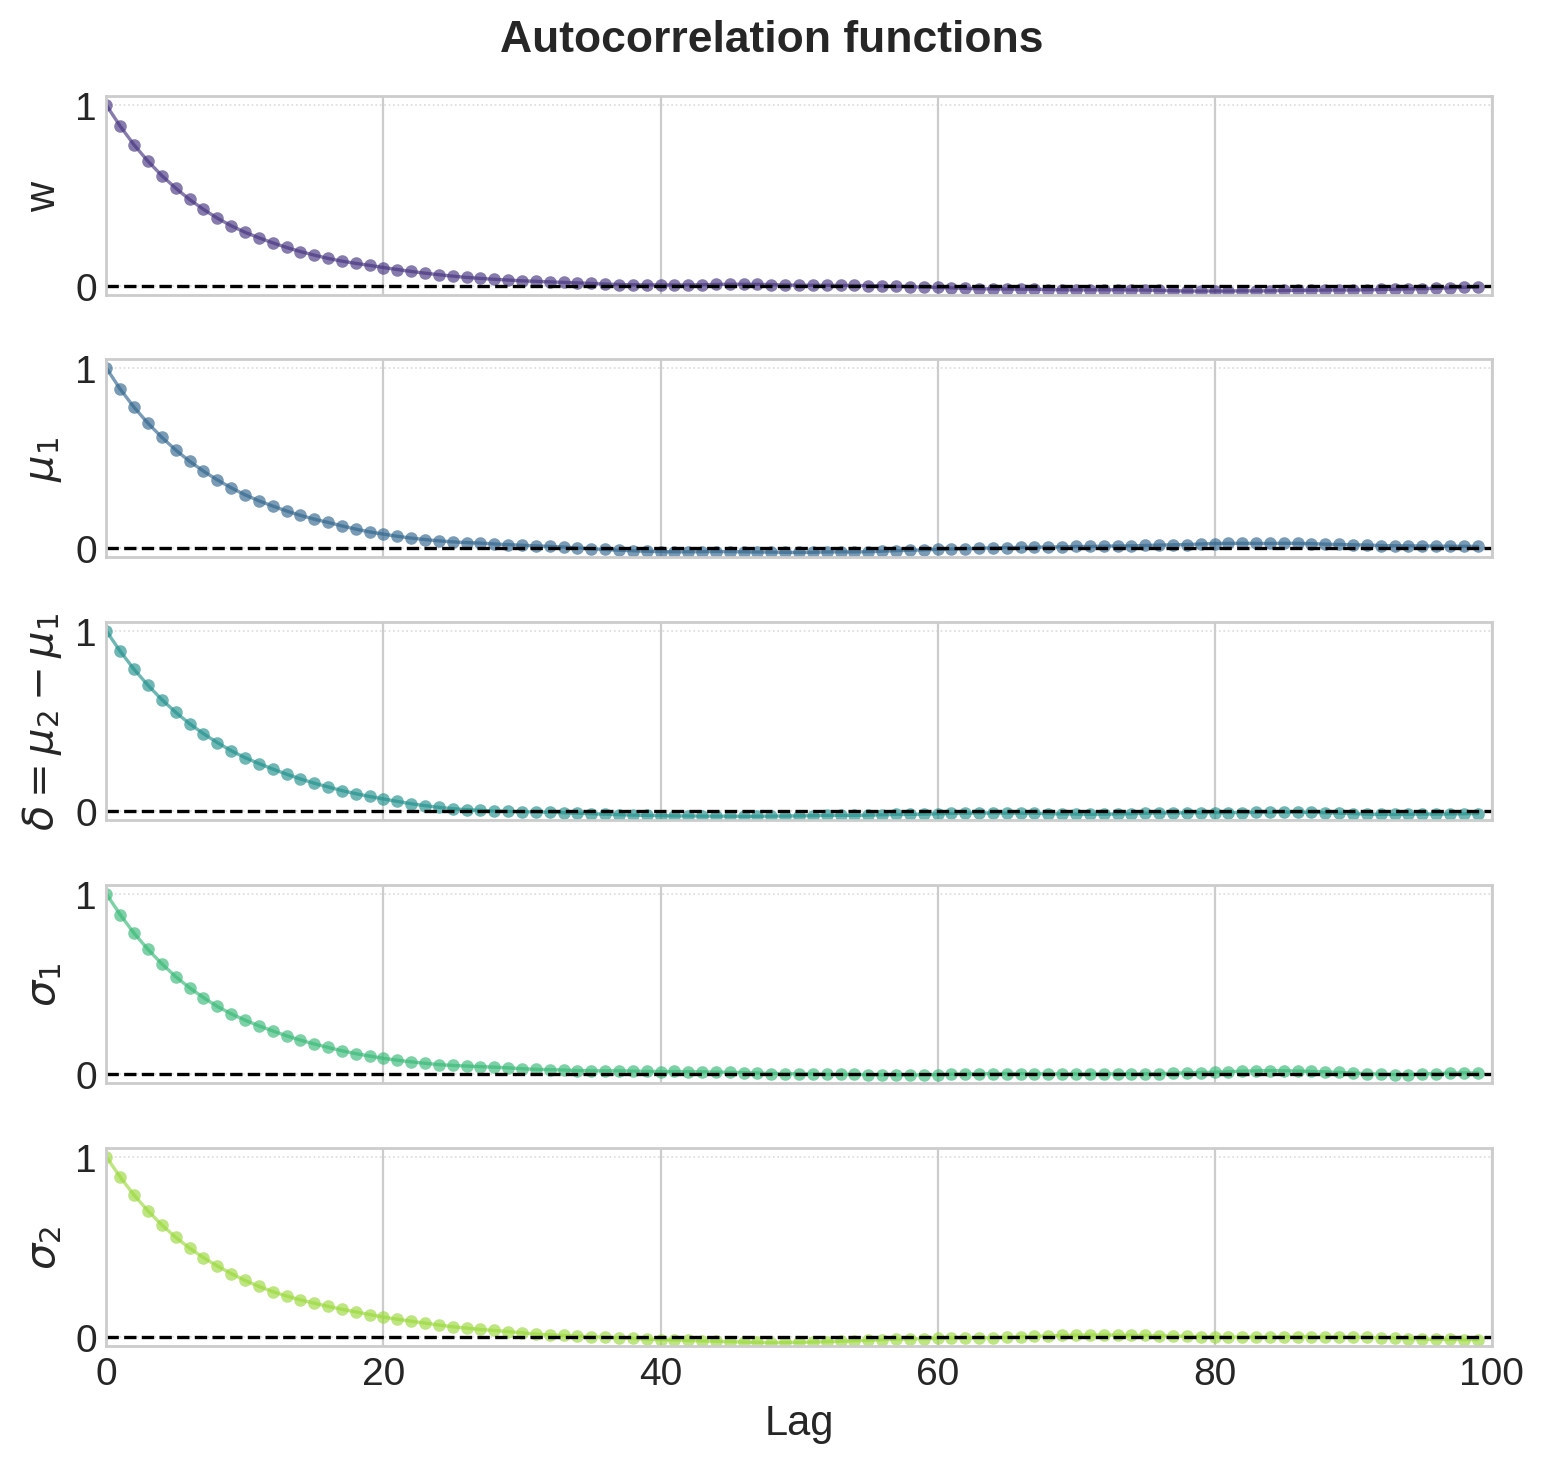

In [47]:
filename = 'autocorrelation_mcmc_final'
fig3, axes3 = plot_autocorrelations(samples_new, filename, max_lag=100, save=True)

In [48]:
for i, key in enumerate(theta_true.keys()):
    print(f'N_ESS ({key}) = {ess(samples_new[:,i]):.0f}')

N_ESS (w) = 3015
N_ESS (mu1) = 3136
N_ESS (mu2) = 3245
N_ESS (sigma1) = 2977
N_ESS (sigma2) = 2928


In [49]:
print('covarianza =\n', cov_est_final)
print('\ncovarianza final =\n', np.cov(samples_new, rowvar=False))

covarianza =
 [[ 1.20398527e-04  6.19615537e-05 -3.35530454e-05  4.94073826e-05
  -3.49279849e-05]
 [ 6.19615537e-05  1.37515318e-03 -1.18348328e-03  2.77299921e-04
  -1.87594714e-04]
 [-3.35530454e-05 -1.18348328e-03  1.90993094e-03 -1.06453525e-04
   3.34344884e-05]
 [ 4.94073826e-05  2.77299921e-04 -1.06453525e-04  8.23332884e-04
  -1.39871180e-04]
 [-3.49279849e-05 -1.87594714e-04  3.34344884e-05 -1.39871180e-04
   5.61177296e-04]]

covarianza final =
 [[ 1.18469911e-04  5.41824007e-05 -1.24522133e-05  4.46707267e-05
  -4.03425662e-05]
 [ 5.41824007e-05  1.36698957e-03 -1.17677392e-03  2.48022150e-04
  -1.88421312e-04]
 [-1.24522133e-05 -1.17677392e-03  1.95074293e-03 -1.07649682e-04
   3.79691082e-05]
 [ 4.46707267e-05  2.48022150e-04 -1.07649682e-04  8.16064977e-04
  -1.22967936e-04]
 [-4.03425662e-05 -1.88421312e-04  3.79691082e-05 -1.22967936e-04
   5.72060434e-04]]


In [50]:
thinning = 20
samples_new = samples_new[::thinning,:]
samples_new.shape

(2500, 5)

/home/leo/Desktop/Bayesian_probability/mcmc_plots.py:273: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(png_path, dpi=300, bbox_inches='tight', pad_inches=0.06)
/home/leo/Desktop/Bayesian_probability/mcmc_plots.py:274: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(pdf_path, dpi=300, bbox_inches='tight', pad_inches=0.06)


Saved: figure/marginal_distribution_mcmc_final.png (PNG 300 dpi) and figure/marginal_distribution_mcmc_final.pdf (PDF)


/home/leo/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


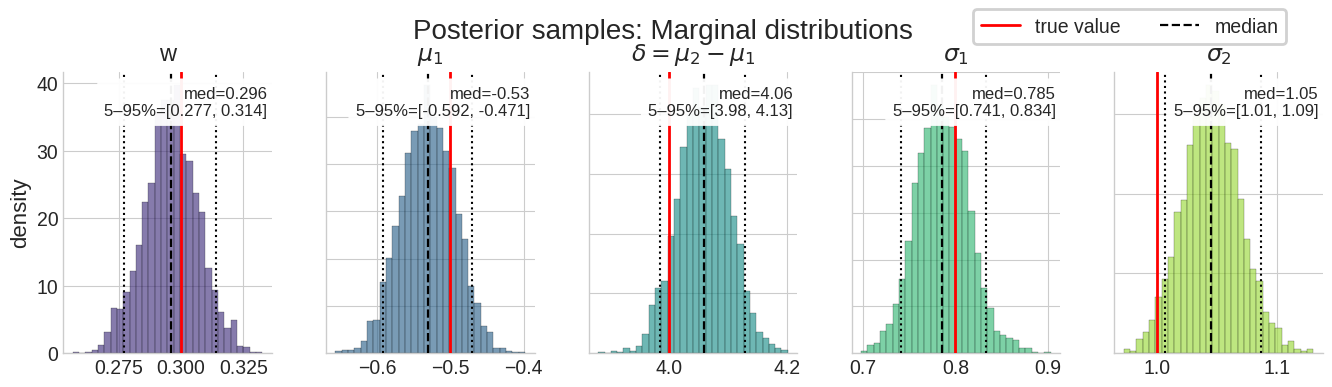

In [51]:
filename = 'marginal_distribution_mcmc_final'
fig2, axes2 = plot_marginal_distributions(samples_new, filename, theta_sim, save=True)

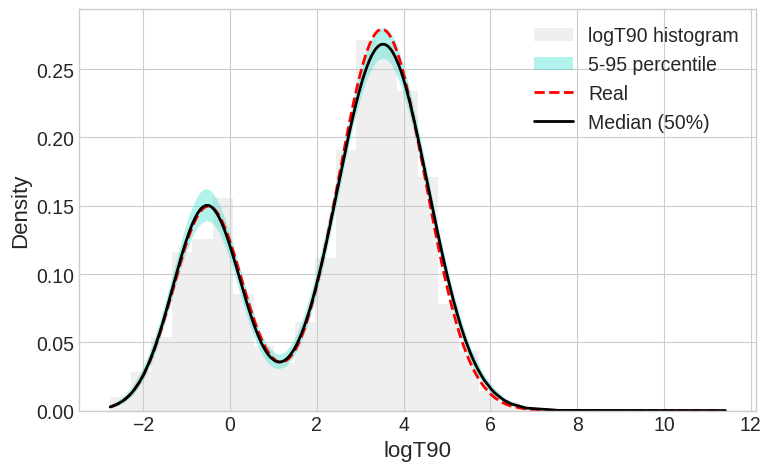

In [52]:
filename = 'distribution_mcmc_final'
fig4, axes4 = plot_distribution(logT90, samples_new, filename, theta_true=theta_sim, save=True)

/home/leo/Desktop/Bayesian_probability/mcmc_plots.py:708: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


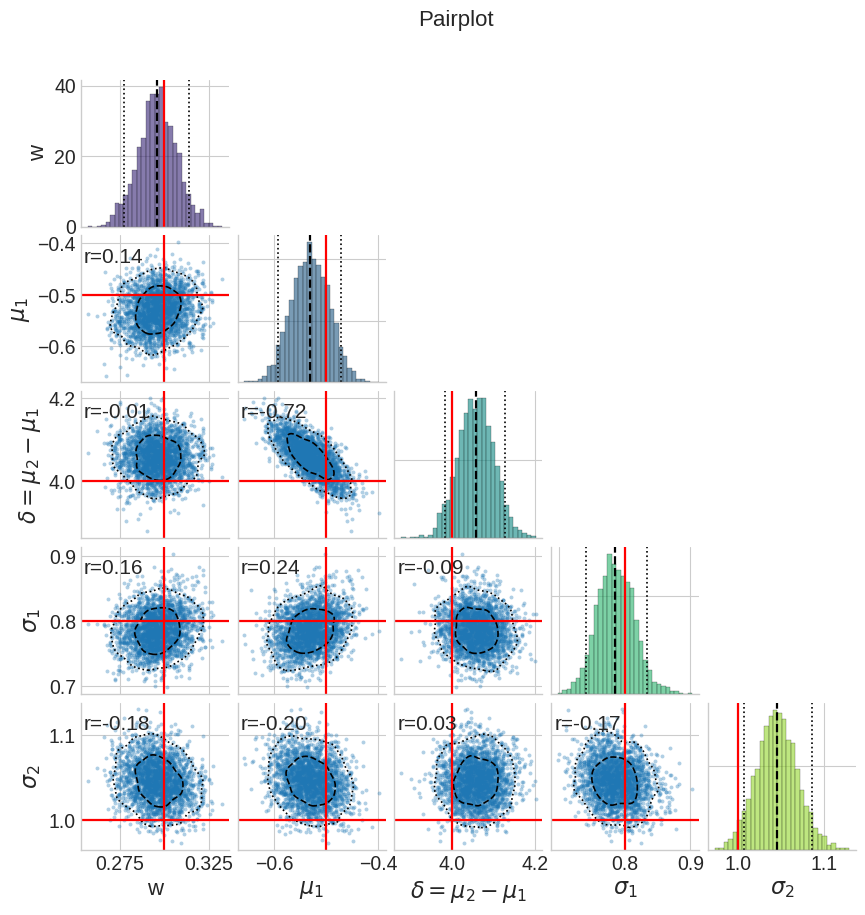

In [53]:
filename = 'Pairplot'
fig5, axes5 = pairplot(samples_new, filename, theta_sim, save=True)